## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [114]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from configs.utils_2 import windowing, windowing_array
from sklearn.model_selection import train_test_split
from configs.utils_2 import split_sequence, split_sequence_long
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Exploration

In [2]:
csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


In [8]:
data.head()

,pos.x,pos.y,pos.z,heading,velocity,weather,Minute sin,Minute cos
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2,-1.792514e-08,1.000000
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2,1.045284e-01,0.994522
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2,2.079117e-01,0.978148
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2,3.090170e-01,0.951057
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2,4.067366e-01,0.913545


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [9]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [10]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [11]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [12]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [13]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [14]:
x_train.shape, y_train.shape

((61296, 48, 8), (61296, 12, 8))

In [15]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(61296, 48, 8)

In [16]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [17]:
y_train.shape

(61296, 12, 2)

In [18]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [19]:
x_test.shape, y_test.shape

((15324, 48, 8), (15324, 12, 8))

In [20]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [21]:
y_test.shape

(15324, 12, 2)

### Model Configuration

In [22]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(48, 8)

In [23]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(12, 2)

In [24]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

24

### Train and evaluate

In [25]:
from models.transformer import ITPF_Transformer


model = ITPF_Transformer()

In [26]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [27]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long_2.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
1533/1533 [==============================] - 96s 61ms/step - loss: 945.9631 - mae: 20.1651 - val_loss: 237.2230 - val_mae: 8.6918 - lr: 0.0010
Epoch 2/100
1533/1533 [==============================] - 99s 65ms/step - loss: 450.0726 - mae: 14.8896 - val_loss: 232.1344 - val_mae: 8.8759 - lr: 0.0010
Epoch 3/100
1533/1533 [==============================] - 101s 66ms/step - loss: 435.4833 - mae: 14.6586 - val_loss: 227.5627 - val_mae: 8.8918 - lr: 0.0010
Epoch 4/100
1533/1533 [==============================] - 102s 67ms/step - loss: 429.8410 - mae: 14.5778 - val_loss: 217.2723 - val_mae: 8.6300 - lr: 0.0010
Epoch 5/100
1533/1533 [==============================] - 105s 69ms/step - loss: 416.1834 - mae: 14.3605 - val_loss: 201.5610 - val_mae: 7.9423 - lr: 0.0010
Epoch 6/100
1533/1533 [==============================] - 105s 69ms/step - loss: 410.0845 - mae: 14.2841 - val_loss: 209.6208 - val_mae: 8.7495 - lr: 0.0010
Epoch 7/100
1533/1533 [==============================] - 106s 69ms

In [28]:
#model.summary()

In [29]:
model = keras.models.load_model("best_model_long_2.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

220/479 [============>.................] - ETA: 4s - loss: 193.7571 - mae: 8.6055

479/479 [==============================] - 8s 17ms/step - loss: 173.1331 - mae: 8.2289
Test accuracy 8.228937149047852
Test loss 173.13311767578125


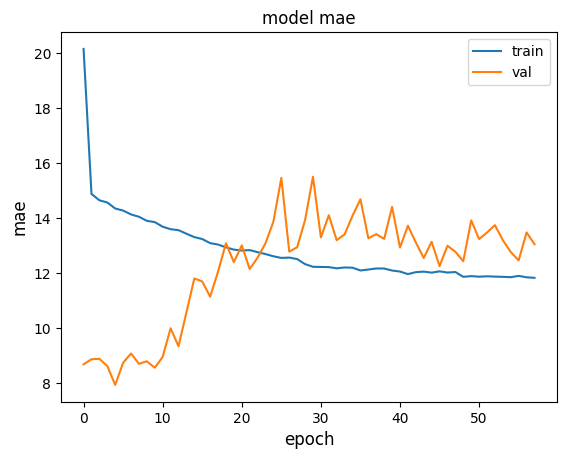

In [30]:
import matplotlib.pyplot as plt

metric = "mae"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Visualize the 10 best predictions

In [31]:
predictions = model.predict(x_test)

375/479 [======================>.......] - ETA: 1s

479/479 [==============================] - 8s 17ms/step


In [32]:
predictions.shape

(15324, 12, 2)

In [33]:
y_true = y_test

In [34]:

# Calculate MSE for each set of predictions
mse_values = np.mean((predictions - y_true) ** 2, axis=(1, 2))

# Find the indices of the 10 predictions with the lowest MSE
best_indices = np.argsort(mse_values)[:10]

# Select the 10 best predictions
best_predictions = predictions[best_indices]

# Retrieve the corresponding x_test entries
best_x_test = x_test[best_indices]
best_y_test = y_test[best_indices]


In [35]:
best_x_test.shape, best_predictions.shape

((10, 48, 8), (10, 12, 2))

Visualize the 10 best predictions


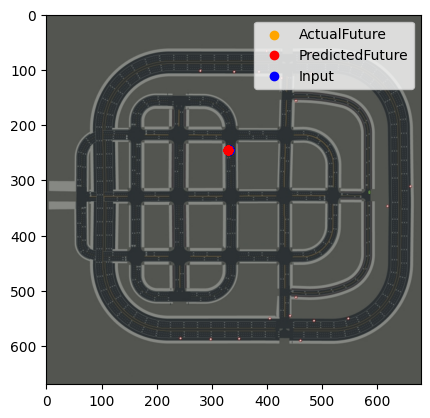

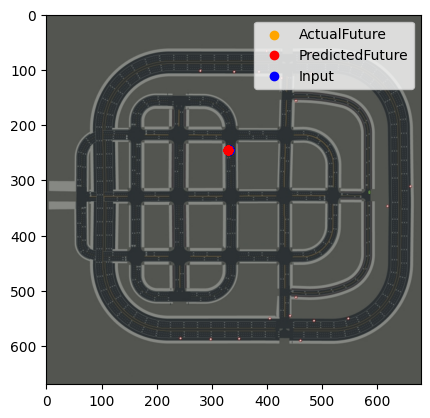

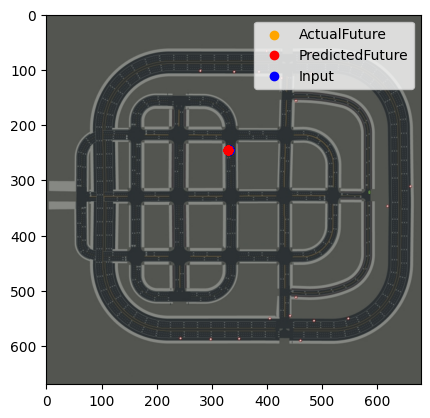

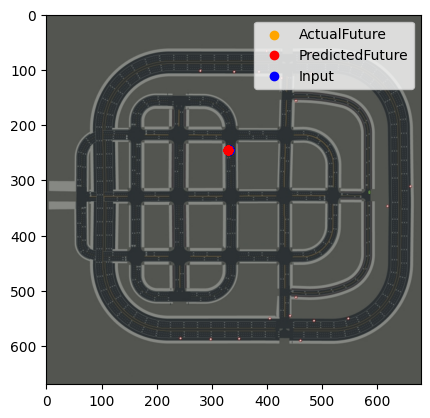

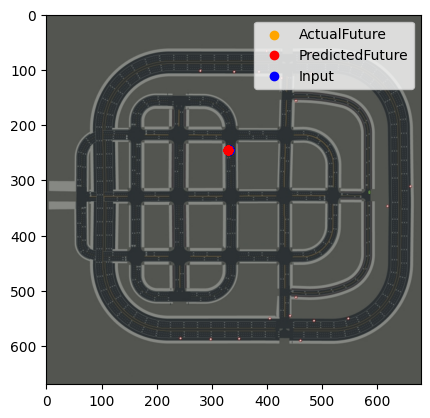

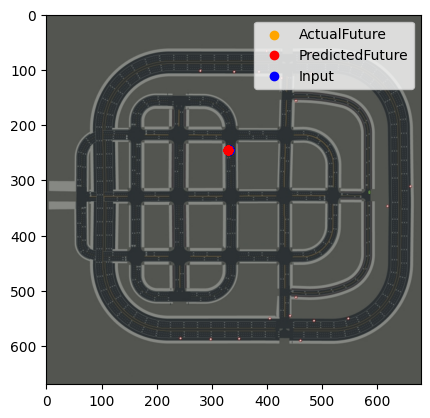

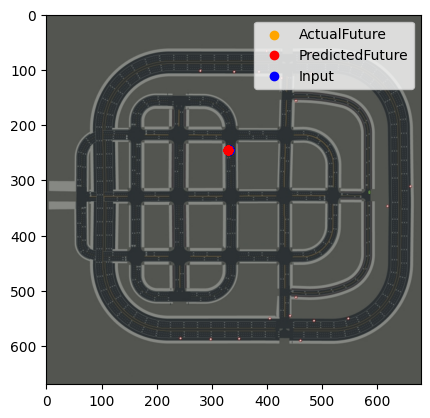

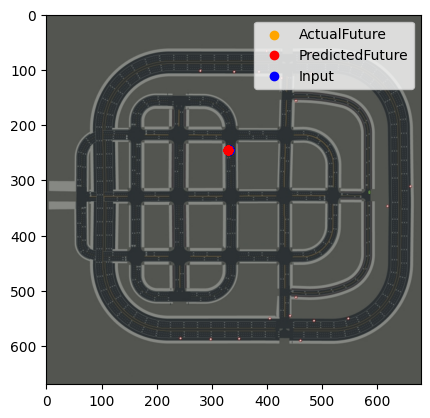

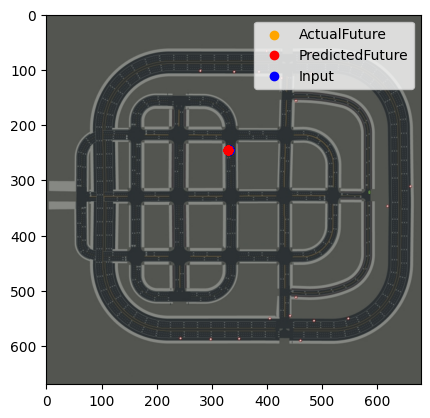

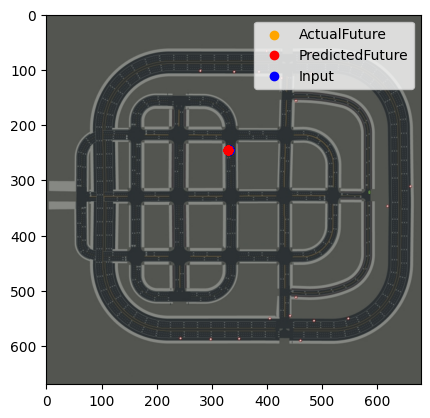

In [36]:
import random
from configs.utils_2 import plot_pred, plot_pred2


print("Visualize the 10 best predictions")

# After finding the best prediction, visualize it
if best_predictions is not None:
    for item in range(best_predictions.shape[0]):
        plot_pred2(best_x_test[:, :, :2][item], best_y_test[item], best_predictions[item])

## Explainer

In [115]:
from explainers.explainer import BlackBoxWrapper, ITPFExplainer

blackbox = BlackBoxWrapper(model=model)
explainer = ITPFExplainer()
explainer.fit_exp(
    model=blackbox, 
    x=x_train, 
    y=y_train, 
    feature_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"], 
    class_names=['pos.x', 'pos.y'],
    feature_nr=8,
    feature_pred_nr=2
)

In [116]:
y=best_x_test[0]

In [117]:
y.shape

(48, 8)

In [118]:
shap_values, pertubed_data = explainer.shap_values_multivariate(y=y)

1/1 [==============================] - 0s 16ms/step


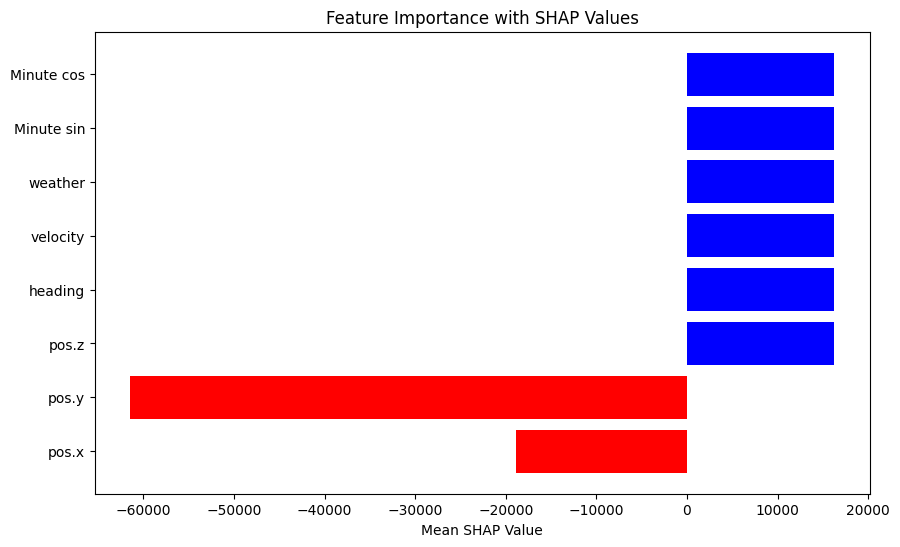

In [119]:
explainer.shap_multivariate(shap_values)

### IMT

In [69]:
import keras.backend as K
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [90]:
from explainers.imt import IMT


explainer = IMT(blackbox.predict_2Dto3D,rmse, best_x_test[0], best_y_test[0], ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"])

['pos.x', 'pos.y', 'pos.z', 'heading', 'velocity', 'weather', 'Minute sin', 'Minute cos']


1/1 [==============================] - 0s 18ms/step


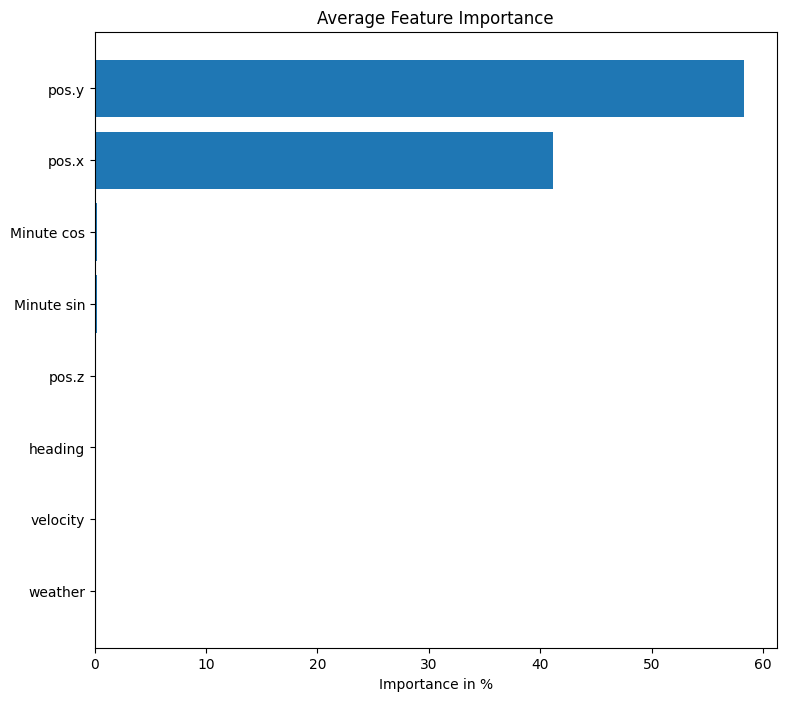

In [91]:
explainer.avg_feature_importance(y)

In [120]:
y

array([[-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
        -1.74361147e-08,  1.00000000e+00],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         1.04528449e-01,  9.94521897e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         2.07911679e-01,  9.78147603e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         3.09016986e-01,  9.51056519e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         4.06736638e-01,  9.13545460e-01],
       [-4.78680420e+01,  6.83461838e+01,  2.52205078e-02,
         5.48877688e-03,  0.00000000e+00,  0.00000000e+00,
         4.99999985e-01,  8.66025413e-01],
       [-4.78680420e+01,  6.834618

In [121]:
pertubed_data

array([[-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
        -1.74361147e-08,  1.00000000e+00],
       [-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
         1.04528449e-01,  9.94521897e-01],
       [-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
         2.07911679e-01,  9.78147603e-01],
       [-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
         3.09016986e-01,  9.51056519e-01],
       [-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
         4.06736638e-01,  9.13545460e-01],
       [-4.78680420e+03,  6.83461838e+03,  2.52205078e+00,
         5.48877688e-01,  0.00000000e+00,  0.00000000e+00,
         4.99999985e-01,  8.66025413e-01],
       [-4.78680420e+03,  6.834618